--- 1. Inspección y Limpieza de Datos ---
Columnas disponibles: ['decibles', 'light_value', 'gravity_x', 'gravity_y', 'gravity_z', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'Time']
Registros limpios: 113

--- 2. Variable Target Creada: Is_Anomaly ---
Anomalías (posibles fallos) detectadas: 8 (7.08%)

--- 3. Resultados de Evaluación del Modelo ---
Matriz de Confusión:
[[32  0]
 [ 0  2]]

Reporte de Clasificación (Métricas):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00         2

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



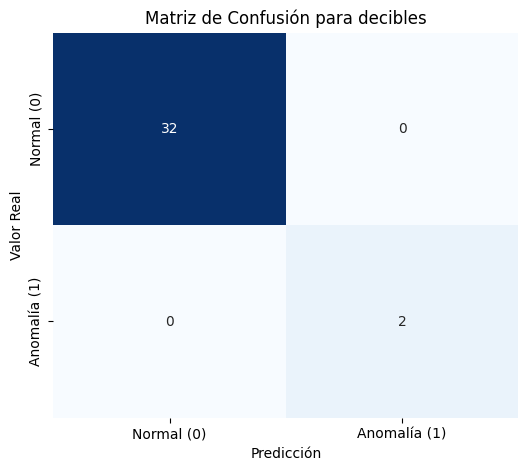

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Definimos la columna del sensor a analizar. Cambiar si se desea analizar 'light_value', etc.
SENSOR_COL = 'decibles'

# =========================================================
# 1. CARGA Y LIMPIEZA DE DATOS
# =========================================================

# Carga del dataset
try:
    df = pd.read_csv('/content/ArduinoSensorValues.csv')
except FileNotFoundError:
    print("Error: El archivo no se encontró.")
    exit()

print("--- 1. Inspección y Limpieza de Datos ---")
print(f"Columnas disponibles: {list(df.columns)}")

# Paso 1a: Convertir la columna seleccionada a numérico
df[SENSOR_COL] = pd.to_numeric(df[SENSOR_COL], errors='coerce')

# Paso 1b: Eliminar filas con NaN en la columna del sensor
df.dropna(subset=[SENSOR_COL], inplace=True)
print(f"Registros limpios: {len(df)}")


# =========================================================
# (Creación de la Target Variable)
# =========================================================

# Usamos el método IQR (Rango Intercuartil) para definir anomalías (Outliers)
Q1 = df[SENSOR_COL].quantile(0.25)
Q3 = df[SENSOR_COL].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Crear la variable target 'Is_Anomaly': 1 si está fuera de los límites, 0 si es normal
df['Is_Anomaly'] = np.where(
    (df[SENSOR_COL] < lower_bound) | (df[SENSOR_COL] > upper_bound),
    1,
    0
)

print(f"\n--- 2. Variable Target Creada: Is_Anomaly ---")
print(f"Anomalías (posibles fallos) detectadas: {df['Is_Anomaly'].sum()} ({df['Is_Anomaly'].mean()*100:.2f}%)")


# =========================================================
# 3. PRE-PROCESAMIENTO, MODELADO Y EVALUACIÓN
# =========================================================

# 3a. Definir Features (X) y Target (y)
X = df[[SENSOR_COL]]
y = df['Is_Anomaly']

# 3b. Escalado de datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3c. División de datos (30% para prueba, 'stratify' para mantener la proporción de anomalías)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 3d. Entrenamiento del Modelo (Random Forest Classifier)
# 'class_weight='balanced' es importante para datasets con desequilibrio de clases
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# 3e. Predicción y Evaluación
y_pred = model.predict(X_test)

print("\n--- 3. Resultados de Evaluación del Modelo ---")
print("Matriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nReporte de Clasificación (Métricas):")
print(classification_report(y_test, y_pred))

# 3f. Visualización de la Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal (0)', 'Anomalía (1)'],
            yticklabels=['Normal (0)', 'Anomalía (1)'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title(f'Matriz de Confusión para {SENSOR_COL}')
plt.savefig('confusion_matrix_decibles.png')